# Curved arch
#### April 2020, Amir Hossein Namadchi
This is an OpenSeesPy simulation of one of the numerical examples in [A robust composite time integration scheme for snap-through problems](https://link.springer.com/article/10.1007/s00466-015-1152-3) by *Yenny Chandra* et. al. It's a special problem involving dynamic snap-through with large deformations in elastic range. In their study, a new three sub-step composite time integration algorithm was presented to handle such problems. Here, I will use the Bathe scheme (`TRBDF2`) to perform transient analysis. 

![Curved Arch](CurvedArch.png)

In [2]:
import numpy as np
from sees import render
import opensees.openseespy as ops
import matplotlib.pyplot as plt

from time import process_time

Below, the base units are defined as python variables:

In [3]:
# Units
mm = 1.0   # milimeters
N = 1.0    # Newtons
sec = 1.0  # Seconds

In [16]:

# Create the model

def arch_model(
    Rise   = 500,
    Offset = 200,
    L      = None, #5000,
    Angle  = None,
    Radius = None,
    ne  = 10):
    

    # Define material parameters
    E = 200
    A = 1e4
    I = 1e8

    # Compute radius
    if Radius is None:
        Radius = Rise/2 + (2*L)**2/(8*Rise)
        th = 2*(np.pi/2 - Angle)
    else:
        L = 0.5*np.sqrt(8*Rise*(Radius - Rise/2))
        th = 2*np.arcsin(L/Radius)

    #
    # Build the model
    #
    model = ops.Model(ndm=2, ndf=3)

    # Create nodes
    nen = 2
    nn  = ne*(nen-1)+1
    mid = (nn+1)//2      # midpoint node

    for i, angle in enumerate(np.linspace(-th/2, th/2, nn)):
        tag = i + 1

        # Compute x and add offset if midpoint
        x = Radius*np.sin(angle)
        if tag == mid:
            x -= Offset

        # Compute y
        y = Radius*np.cos(angle) - Radius*np.cos(-th/2)

        # create the node
        model.node(tag, x, y)


    # Create elements
    transfTag = 1
    model.geomTransf("Corotational", transfTag)
    for i in range(ne):
        tag   = i+1
        nodes = (i+1, i+2)
        model.element("ElasticBeamColumn", tag, *nodes, A, E, I, transfTag)


    model.fix( 1, 1, 1, 0)
    model.fix(nn, 1, 1, 0)
    
    # Create a load pattern that scales linearly
    model.pattern("Plain", 1, "Linear")

    # Add a nodal load to the pattern
    model.load(mid, 0.0, -1.0, 0.0, pattern=1)

    
    model.system("ProfileSPD")
    # model.system("FullGeneral")
    # model.system("BandGeneral")
    # model.system("Umfpack", det=True)

    model.test("NormUnbalance", 1e-6, 25, 0)
    model.algorithm("Newton")
    model.analysis("Static")


    return model, mid

arch_model(15.39553, 0, Angle=0.2014, Radius=762, ne=20)

(<opensees.openseespy.Model at 0x7f5666f598e0>, 11)

### Model Defintion

In [ ]:
# Node Coordinates Matrix (size : nn x 3)
node_coords = np.array([[-152.4, 0], [-137.337, 2.91714],
                        [-122.218, 5.53039], [-107.049, 7.8387],
                        [-91.8371, 9.84114], [-76.5878, 11.5369],
                        [-61.3076, 12.9252], [-46.0024, 14.0057],
                        [-30.6787, 14.7777], [-15.3424, 15.2411],
                        [0, 15.3955], [15.3424, 15.2411], 
                        [30.6787, 14.7777], [46.0024, 14.0057],
                        [61.3076, 12.9252], [76.5878, 11.5369], 
                        [91.8371, 9.84114], [107.049, 7.8387], 
                        [122.218, 5.53039], [137.337, 2.91714],
                        [152.4, 0]], dtype = np.float64)*mm

# Element Connectivity Matrix (size: nel x 2)
connectivity = [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], 
                [6, 7], [7, 8], [8, 9], [9, 10], [10, 11],
                [11, 12], [12, 13], [13, 14], [14, 15], 
                [15, 16], [16, 17], [17, 18], [18, 19],
                [19, 20], [20, 21]]

# Get Number of total Nodes
nn = len(node_coords)
# Get Number of total Elements
nel = len(connectivity)

#Boundary Conditions (size: fixed_nodes x 4)
B_C = [[1,1,1,1],
       [nn,1,1,1]]


# Modulus of Elasticity
E = 206843*(N/mm**2)
# Mass Density
rho = (7.83e-9)*(N*(sec**2)/(mm**4))
# Cross-sectional area, 2nd Moment of Inertia
A   = 12.7*0.6096*mm*mm
I   = (1/12)*(12.7*(0.6096**3))*mm**4

In [ ]:
model = ops.Model( ndm=2, ndf=3)

# Adding nodes to the model object using list comprehensions
for n in range(nn):
    model.node(n+1,*node_coords[n])

# Applying BC
for n in range(len(B_C)):
    model.fix(B_C[n][0],*B_C[n][1:])


# Define Transformation
model.geomTransf('Corotational', 1)

# Adding Elements
for e in range(nel):
     model.element('elasticBeamColumn', e+1, *connectivity[e], 
                   A, E, I, 1, '-mass', rho*A,'-cMass',1)

## Loading

In [ ]:
# load function (Applied @ top node)
F = lambda t: (t if t<=8 else 8)*N

# Dynamic Analysis Parameters
dt = 0.0001
time = 15
time_domain = np.arange(0,time,dt)

# Loading Definition
model.timeSeries('Path', 1 , dt=dt,
                 values=np.vectorize(F)(time_domain),
                 time=time_domain)
model.pattern('Plain', 1, 1)
model.load(11, *[0.0, -1.0, 0.0], pattern=1)


In [4]:

# Analysis
model.constraints('Transformation')
model.numberer('RCM')
model.system('ProfileSPD')
model.test('NormUnbalance', 1e-6, 100)
model.algorithm('Newton')
model.integrator('TRBDF2')
model.analysis('Transient')


# let's do this
time = []     # list to hold time stations for plotting
d_list = []      # list to hold vertical displacments of the top node

# start the timer
tic = process_time()

for i in range(len(time_domain)):
    model.analyze(1, dt)
    time.append(model.getTime())
    d_list.append(model.nodeDisp(11,2))

# stop the timer
toc = process_time()   

print('Time elapsed:',toc-tic, 'sec')

Time elapsed: 44.4480693 sec


### Visualization

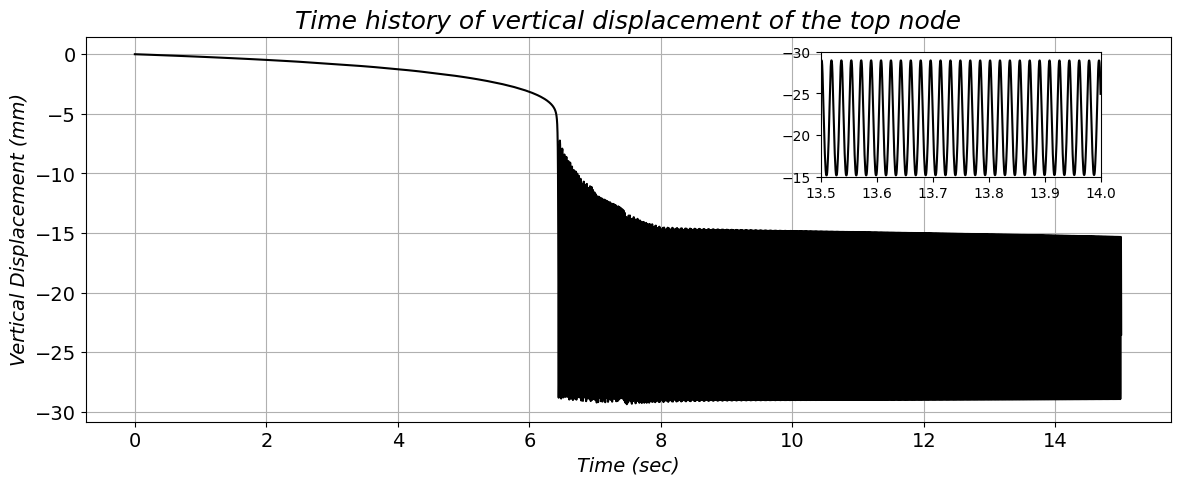

In [6]:
plt.figure(figsize=(14,5))
ax1 = plt.axes()  # standard axes
plt.grid()
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.title('Time history of vertical displacement of the top node',
          {'fontstyle':'italic','size':18});

ax2 = plt.axes([0.65, 0.60, 0.2, 0.25])


ax1.plot(time, d_list,'k')
ax2.plot(time, d_list,'k')
ax2.set_xlim(left=13.5, right=14)
ax2.set_ylim(bottom=-15, top=-30)

ax1.set_xlabel('Time (sec)', {'fontstyle':'italic','size':14})
ax1.set_ylabel('Vertical Displacement (mm)', {'fontstyle':'italic','size':14});


### Closure
The figure deomnstrates a dynamic jump from the quasi static configuration. It then begins to oscillate around the remote equilibrium configuration. It is to be noted that conventional time integration algorithm like the *Newmark* method might not be able to present a stable and bounded solution like this. It is therefore necessary to employ an energy-conserving algorithms with proper numerical dissipation in order to tackle these kind of problems (like `TRBDF2` and `TRBDF3` in OpenSees).

### References
- <blockquote>Chandra, Y., Zhou, Y., Stanciulescu, I., Eason, T. and Spottswood, S., 2015. A robust composite time integration scheme for snap-through problems. Computational Mechanics, 55(5), pp.1041-1056.</blockquote>